In [1]:
import os
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
#from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
#from helper_functions.invertible_neural_network_positive import InvertibleNetworkSurrogate

from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, mean_absolute_percentage_error

import PyMieScatt as pms

2023-01-13 09:46:17.387796: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-13 09:46:17.388760: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 09:46:17.388986: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dlogD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log10(GSD)))) * np.exp(-(np.log10(D_array)-np.log10(D_median))**2/(2*(np.log10(GSD)**2)))   # cm-3
    return n

def lognormal_fit(PSD, diameters, init_guess, fit_bounds):
    #fit_bounds=([0,0,2,0,0,3],[np.inf,1.25,5,np.inf,1.25,10])
    pu, pcovu = curve_fit(lognormal, diameters, PSD, p0=init_guess, bounds=fit_bounds, max_nfev=1e4)
    return(pu, pcovu)

def interp(df, new_index):
    """Return a new DataFrame with all columns values interpolated
    to the new_index values."""
    df_out = pd.DataFrame(index=new_index)
    df_out.index.name = df.index.name

    for colname, col in df.iteritems():
        df_out[colname] = np.interp(new_index, df.index, col)

    return df_out

def read_results(qoi, var='F11'):
    F11 = [x for x in qoi.index if var in x]
    index_list = [int(x[10:]) for x in F11]
    values = qoi[F11].values
    output = pd.DataFrame(index=index_list, columns=[var])
    output[var] = values
    return output

def run_pymiescatt(R_median, GSD, N_tot, ri_n, ri_k, wvl, angles, D_array):
    '''
    R_median in um (NOTE: this is the median radius of the NUMBER size distribution!)
    N_tot in cm-3
    ri_k as positive float number
    wvl in um
    angles is the array of angles
    D_array is the diameter array in nm
    '''
    lambd = wvl *1e3   # from um to nm
    m = ri_n + 1j * ri_k
    mu = np.cos(angles * np.pi / 180)
    
    n = lognormal(D_array, R_median*2 * 1e3, GSD, N_tot)/D_array / 2.303
    
    cscat = []
    for d in D_array:
            cscat_temp = pms.MieQ(m, lambd, d, asCrossSection=True)[1]
            cscat.append(cscat_temp)
    
    S11 = []
    S11_test = []
    S12 = []
    for diam in D_array:
        x = diam * np.pi / lambd
        theta, SL, SR, S11_temp = pms.ScatteringFunction(m, lambd, diam,
                                                        minAngle=angles.min(), maxAngle=angles.max(),
                                                        angularResolution=angles[1]-angles[0],
                                                        normalization=None)
        S11_test.append(S11_temp)
        # S11.append(S11_temp / np.trapz(S11_temp, x=np.flip(mu)) / (2*np.pi))
        qscat_temp = pms.MieQ(m, lambd, diam, asCrossSection=False)[1]
        S11.append(S11_temp / (qscat_temp * x**2 * np.pi))
        
        # S12.append( (0.5*(SR-SL)) / np.trapz(S11_temp, x=np.flip(mu)) / (2*np.pi))
        S12.append( (0.5*(SR-SL)) / (qscat_temp * x**2 * np.pi))
    S11 = np.array(S11).T
    # S11_test = np.array(S11_test).T
    S12 = np.array(S12).T            
         
    F11 = np.trapz(S11 * n * cscat * 1e-6, x=D_array)
    # F11_test = np.trapz(S11_test * n * (lambd / 4 / np.pi)**2 * 1e-6, x=D_array)
    F12 = np.trapz(S12 * n * cscat * 1e-6, x=D_array)
    PPF = - F12 / F11 
    
    pymiescatt = pd.DataFrame(index=angles, columns=['F11', 'F12', 'PPF'])
    pymiescatt['F11'] = F11
    # pymiescatt['F11_test'] = F11_test
    pymiescatt['F12'] = F12
    pymiescatt['PPF'] = PPF
    
    return pymiescatt

### Load measurements

In [3]:
datafile= '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221219.h5'

uneph_qoi_plot = pd.read_hdf(datafile,'qoi')
uneph_dvar_plot = pd.read_hdf(datafile,'param')

uneph_qoi_plot = uneph_qoi_plot.astype(np.float64)
uneph_dvar_plot = uneph_dvar_plot.astype(np.float64)

In [4]:
# Remove the "_0.532" from the column names
uneph_qoi_plot.columns = uneph_qoi_plot.columns.str.replace(r'_0.532_', '_')

/tmp/ipykernel_44462/994294170.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  uneph_qoi_plot.columns = uneph_qoi_plot.columns.str.replace(r'_0.532_', '_')


In [5]:
# Prepare data for input to the model --> np.log(F11 /4 /np.pi)

F11_list = [x for x in uneph_qoi_plot.columns if 'F11' in x]
PPF_list = [x for x in uneph_qoi_plot.columns if 'PPF' in x]

uneph_qoi = uneph_qoi_plot.copy()
uneph_qoi[F11_list] = np.log( uneph_qoi[F11_list] / 4 / np.pi )
uneph_qoi[PPF_list] = ( uneph_qoi[PPF_list] )

### Load PyMieScatt simulations
F11 and PPF are calculated with PyMieScatt using as state parameters the values "dvar" stored in the uneph .h5 file

In [6]:
pms_qoi_plot = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5', key='qoi')


### Load the model to test

In [7]:
model_name = 'invertible_model'
val_model_name = 'forward_model'

# Model directory
directory = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/invertible_models_iv1_small'
model_dir = directory + '/models'

# Plot directory (subdirectory of the model)
test_directory = '/data/project/general/aerosolretriev/aerosol_results_january_2023/results_Barbara/test_to_be_cancelled'
plot_dir = test_directory +'/plots/model'
#plot_dir = model_dir +'/plots/measurements'

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [8]:
custom_objects = {'AdjustedRSquared':AdjustedRSquared}

kwargs = {'custom_objects':custom_objects, 'compile': False}

surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

#### Inverse prediction 
From F11 and PPF to state parameters

In [9]:
start = time.time()
uneph_dvar_pred_iv_original = surr.sample_n_tries(uneph_qoi.values, batch_size=8, n_tries=32)
end = time.time()
dt = (end-start)#/len(dvar_test)

uneph_dvar_pred_iv = pd.DataFrame(data=uneph_dvar_pred_iv_original, columns=uneph_dvar_plot.columns)

print('Time for the inverse prediction: %i s' %dt)

2023-01-13 09:46:18.519749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-13 09:46:18.520284: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Time for the inverse prediction: 2 s


In [10]:
uneph_dvar_pred_iv_plot = uneph_dvar_pred_iv.copy()
uneph_dvar_pred_iv_plot['Vtot'] = np.exp(uneph_dvar_pred_iv_plot['Vtot'])
uneph_dvar_pred_iv_plot['RmedianV'] = (np.exp(uneph_dvar_pred_iv_plot['RmedianV']) )*1e-3
uneph_dvar_pred_iv_plot['GSD'] = np.exp(uneph_dvar_pred_iv_plot['GSD'])+1
uneph_dvar_pred_iv_plot['n'] = np.exp(uneph_dvar_pred_iv_plot['n'])+1.33
uneph_dvar_pred_iv_plot['k'] = np.exp(uneph_dvar_pred_iv_plot['k'])

#### Forward prediction
From state parameters to F11 and PPF

In [11]:
start = time.time()
uneph_qoi_pred_fw_original = surr.predict(uneph_dvar_pred_iv.values)
end = time.time()
dt = (end-start)#/len(dvar_test)

uneph_qoi_pred_fw = pd.DataFrame(data=uneph_qoi_pred_fw_original, columns=uneph_qoi_plot.columns)

print('Time for the forward prediction: %i s' %dt)

Time for the forward prediction: 0 s


In [12]:
# Process the data for the plots --> np.exp(F11)

uneph_qoi_pred_fw_plot = uneph_qoi_pred_fw.copy()
uneph_qoi_pred_fw_plot[F11_list] = np.exp(uneph_qoi_pred_fw_plot[F11_list])
uneph_qoi_pred_fw_plot[PPF_list] = (uneph_qoi_pred_fw_plot[PPF_list])

### Calculate F11 and PPF using PyMieScatt and state parameters from INN

In [13]:
angles = np.arange(0,180,1)
D_array = np.logspace(0.1, 5, 300)
nstd = 10

pms_pred_qoi = pd.DataFrame(index=np.arange(0, 14), columns=np.arange(0, 360))

for idx, row in uneph_dvar_pred_iv_plot.iterrows():
    
    DmedianV = row['RmedianV']*2  # [um]
    lowerD = DmedianV / row['GSD'] / nstd
    upperD = DmedianV * row['GSD'] * nstd
    D_array = np.logspace(np.log10(lowerD*1e3),np.log10(upperD*1e3), 301) # nm
    
    DmedianN = (np.exp(np.log(row['RmedianV']*2) - (3*np.log(row['GSD'])**2))) *1e3   # [nm]
    Ntot = 6 / np.pi * row['Vtot']*1e9 / (np.exp((3*np.log(DmedianN)) + (4.5*np.log(row['GSD'])**2))) # [cm^-3]

    pms_tmp = run_pymiescatt(DmedianN/2*1e-3, row['GSD'], Ntot, row['n'], row['k'], 0.532, angles, D_array)
    pms_pred_qoi.iloc[idx] = np.concatenate([pms_tmp['F11'].T.values, pms_tmp['PPF'].T.values])
   

### Measurements + PyMieScatt  + Model

In [14]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
theta = np.concatenate([angles1, angles2])

#### PSL

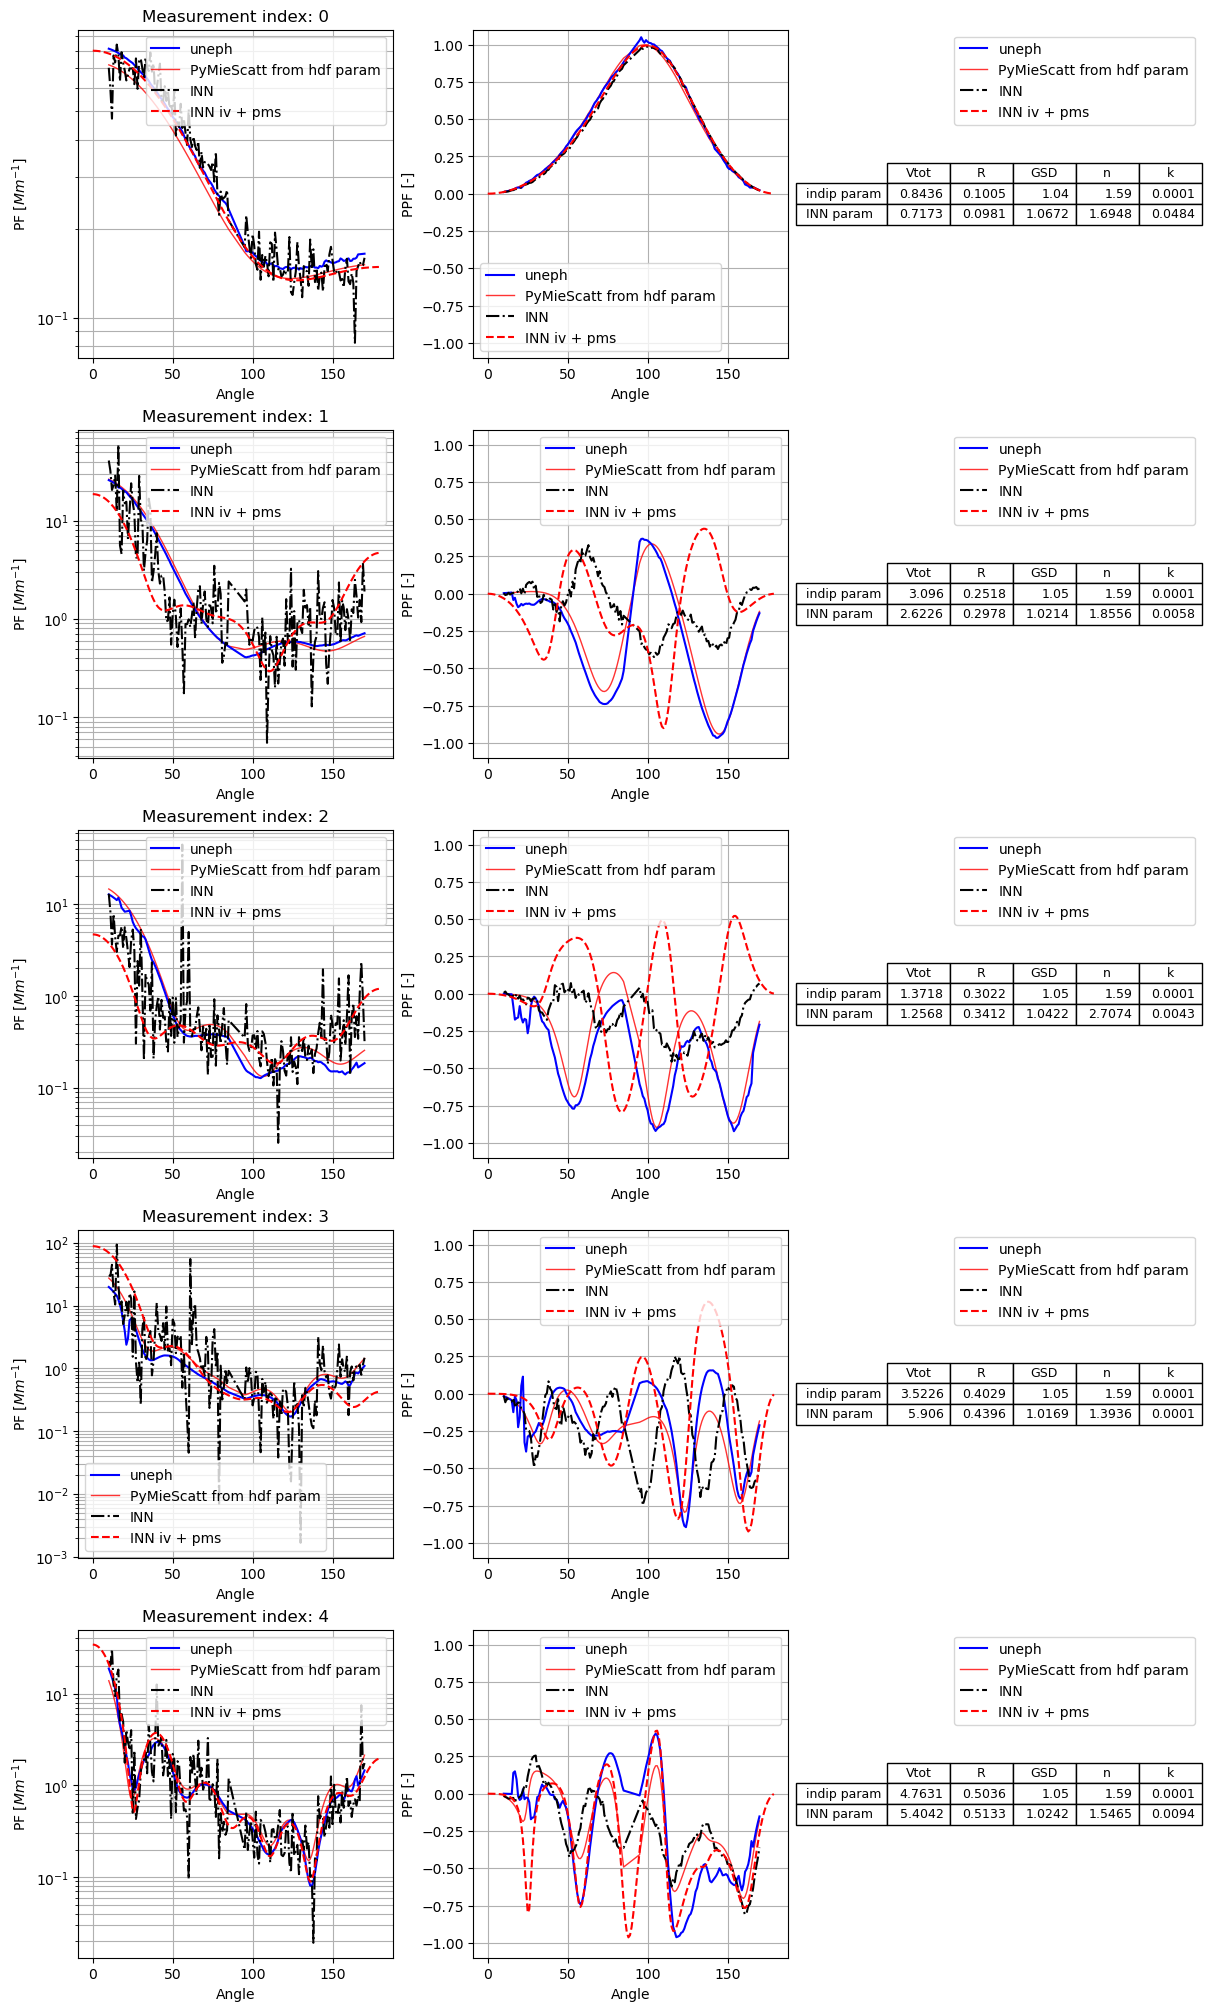

In [15]:
fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(12, 20), constrained_layout=True)

idx = 0

for index in np.arange(0, 5):
    axs[idx, 0].set_title('Measurement index: '+str(index))

    pms_plot, = axs[idx, 0].plot(theta, pms_qoi_plot[F11_list].loc[index], ls='-', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_plot, = axs[idx, 1].plot(theta, pms_qoi_plot[PPF_list].loc[index], ls='-', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_plot, = axs[idx, 0].plot(theta, uneph_qoi_plot[F11_list].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_plot, = axs[idx, 1].plot(theta, uneph_qoi_plot[PPF_list].loc[index].values, c= 'b', label = 'uneph')
    
    meas_pred_plot, = axs[idx, 0].plot(theta, uneph_qoi_pred_fw_plot[F11_list].loc[index].values,ls='-.', c= 'k', label = 'INN')
    meas_pred_plot, = axs[idx, 1].plot(theta, uneph_qoi_pred_fw_plot[PPF_list].loc[index].values,ls='-.', c= 'k', label = 'INN')
    
    pms_pred_qoi_plot, = axs[idx, 0].plot(angles, pms_pred_qoi.iloc[index, :180], ls='--', c='r', label='INN iv + pms')
    pms_pred_qoi_plot, = axs[idx, 1].plot(angles, pms_pred_qoi.iloc[index, 180:], ls='--', c='r', label='INN iv + pms')
    
    axs[idx,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[idx,1].set_ylabel('PPF [-]')
    axs[idx,1].set_ylim(-1.1, 1.1)
    axs[idx,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot, pms_plot, meas_pred_plot, pms_pred_qoi_plot])
        ax.grid(which='both')
    
    # table
    indip_param = uneph_dvar_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    model1_param = uneph_dvar_pred_iv_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)

    col_labels=['Vtot','R','GSD','n', 'k']
    row_labels=['indip param', 'INN param']
    
    # the rectangle is where I want to place the table
    axs[idx, 2].axis('off')
    axs[idx, 2].table(cellText=[indip_param, model1_param],
                  colWidths = [0.2]*5,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center', fontsize=20)
    idx += 1
fig.savefig(f'{plot_dir}/PF_PPF_predi_PSL.jpg')

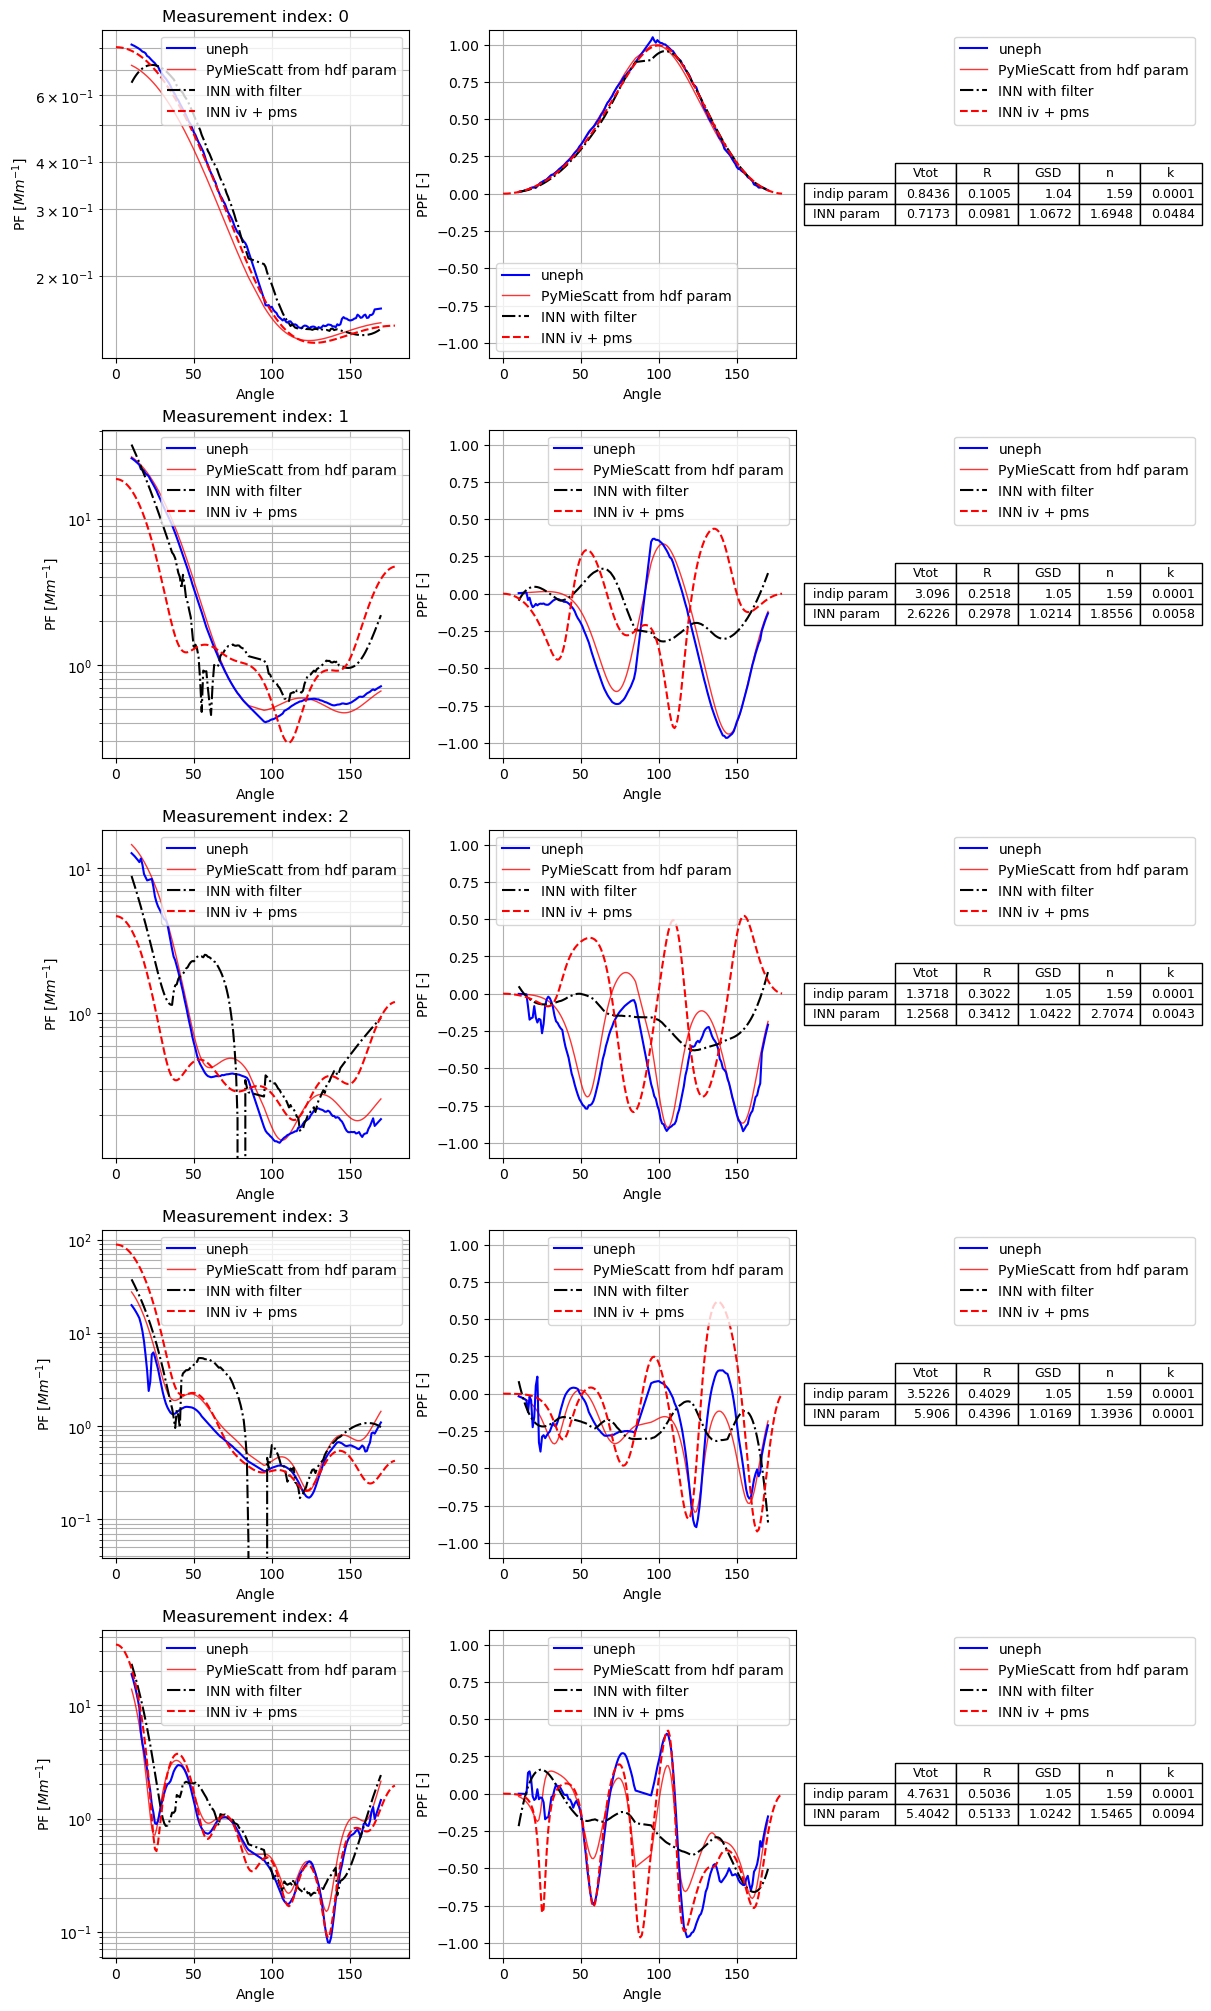

In [16]:
fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(12, 20), constrained_layout=True)

idx = 0

for index in np.arange(0, 5):
    axs[idx, 0].set_title('Measurement index: '+str(index))

    pms_plot, = axs[idx, 0].plot(theta, pms_qoi_plot[F11_list].loc[index], ls='-', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_plot, = axs[idx, 1].plot(theta, pms_qoi_plot[PPF_list].loc[index], ls='-', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_plot, = axs[idx, 0].plot(theta, uneph_qoi_plot[F11_list].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_plot, = axs[idx, 1].plot(theta, uneph_qoi_plot[PPF_list].loc[index].values, c= 'b', label = 'uneph')
    
    meas_pred_plot, = axs[idx, 0].plot(theta, signal.savgol_filter(uneph_qoi_pred_fw_plot[F11_list].loc[index].values, 53, 3),ls='-.', c= 'k', label = 'INN with filter')
    meas_pred_plot, = axs[idx, 1].plot(theta, signal.savgol_filter(uneph_qoi_pred_fw_plot[PPF_list].loc[index].values, 53, 3),ls='-.', c= 'k', label = 'INN with filter')
    
    pms_pred_qoi_plot, = axs[idx, 0].plot(angles, pms_pred_qoi.iloc[index, :180], ls='--', c='r', label='INN iv + pms')
    pms_pred_qoi_plot, = axs[idx, 1].plot(angles, pms_pred_qoi.iloc[index, 180:], ls='--', c='r', label='INN iv + pms')
    
    axs[idx,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[idx,1].set_ylabel('PPF [-]')
    axs[idx,1].set_ylim(-1.1, 1.1)
    axs[idx,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot, pms_plot, meas_pred_plot, pms_pred_qoi_plot])
        ax.grid(which='both')
    
    # table
    indip_param = uneph_dvar_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    model1_param = uneph_dvar_pred_iv_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)

    col_labels=['Vtot','R','GSD','n', 'k']
    row_labels=['indip param', 'INN param']
    
    # the rectangle is where I want to place the table
    axs[idx, 2].axis('off')
    axs[idx, 2].table(cellText=[indip_param, model1_param],
                  colWidths = [0.2]*5,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center', fontsize=20)
    idx += 1
fig.savefig(f'{plot_dir}/PF_PPF_predi_PSL_filtered.jpg')

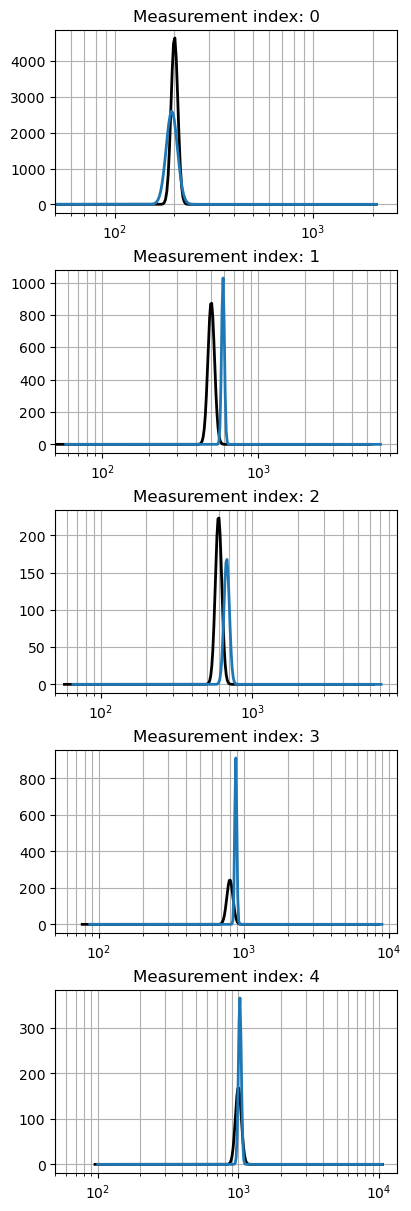

In [17]:
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(4, 12), constrained_layout=True)


for idx, row in uneph_dvar_plot[0:5].iterrows():
    
    axs[idx].set_title('Measurement index: '+str(idx))
    
    # measurements
    DmedianV = row['RmedianV']*2  # [um]
    lowerD = DmedianV / row['GSD'] / nstd
    upperD = DmedianV * row['GSD'] * nstd
    D_array = np.logspace(np.log10(lowerD*1e3),np.log10(upperD*1e3), 301) # nm
    DmedianN = (np.exp(np.log(row['RmedianV']*2) - (3*np.log(row['GSD'])**2))) *1e3   # [nm]
    Ntot = 6 / np.pi * row['Vtot']*1e9 / (np.exp((3*np.log(DmedianN)) + (4.5*np.log(row['GSD'])**2))) # [cm^-3]
    axs[idx].plot(D_array, lognormal(D_array, DmedianN, row['GSD'], Ntot), c='k', ls='-', lw=2, label='measurement')

    # predictions
    DmedianV_pred = uneph_dvar_pred_iv_plot['RmedianV'].iloc[idx]*2  # [um]
    lowerD_pred = DmedianV_pred / uneph_dvar_pred_iv_plot['GSD'].iloc[idx] / nstd
    upperD_pred = DmedianV_pred * uneph_dvar_pred_iv_plot['GSD'].iloc[idx] * nstd
    D_array_pred = np.logspace(np.log10(lowerD_pred*1e3),np.log10(upperD_pred*1e3), 301) # nm
    DmedianN_pred = (np.exp(np.log(uneph_dvar_pred_iv_plot['RmedianV'].iloc[idx]*2) - (3*np.log(uneph_dvar_pred_iv_plot['GSD'].iloc[idx])**2))) *1e3   # [nm]
    Ntot_pred = 6 / np.pi * uneph_dvar_pred_iv_plot['Vtot'].iloc[idx]*1e9 / (np.exp((3*np.log(DmedianN_pred)) + (4.5*np.log(uneph_dvar_pred_iv_plot['GSD'].iloc[idx])**2))) # [cm^-3]
    axs[idx].plot(D_array_pred, lognormal(D_array_pred, DmedianN_pred, uneph_dvar_pred_iv_plot['GSD'].iloc[idx], Ntot_pred), c='C0', ls='-', lw=2, label='INN prediction')

    axs[idx].set_xscale('log')
    axs[idx].grid(which='both')
    axs[idx].set_xlim(50, )
fig.savefig(f'{plot_dir}/size_distrib_predi_PSL.jpg')


#### NIGROSINE

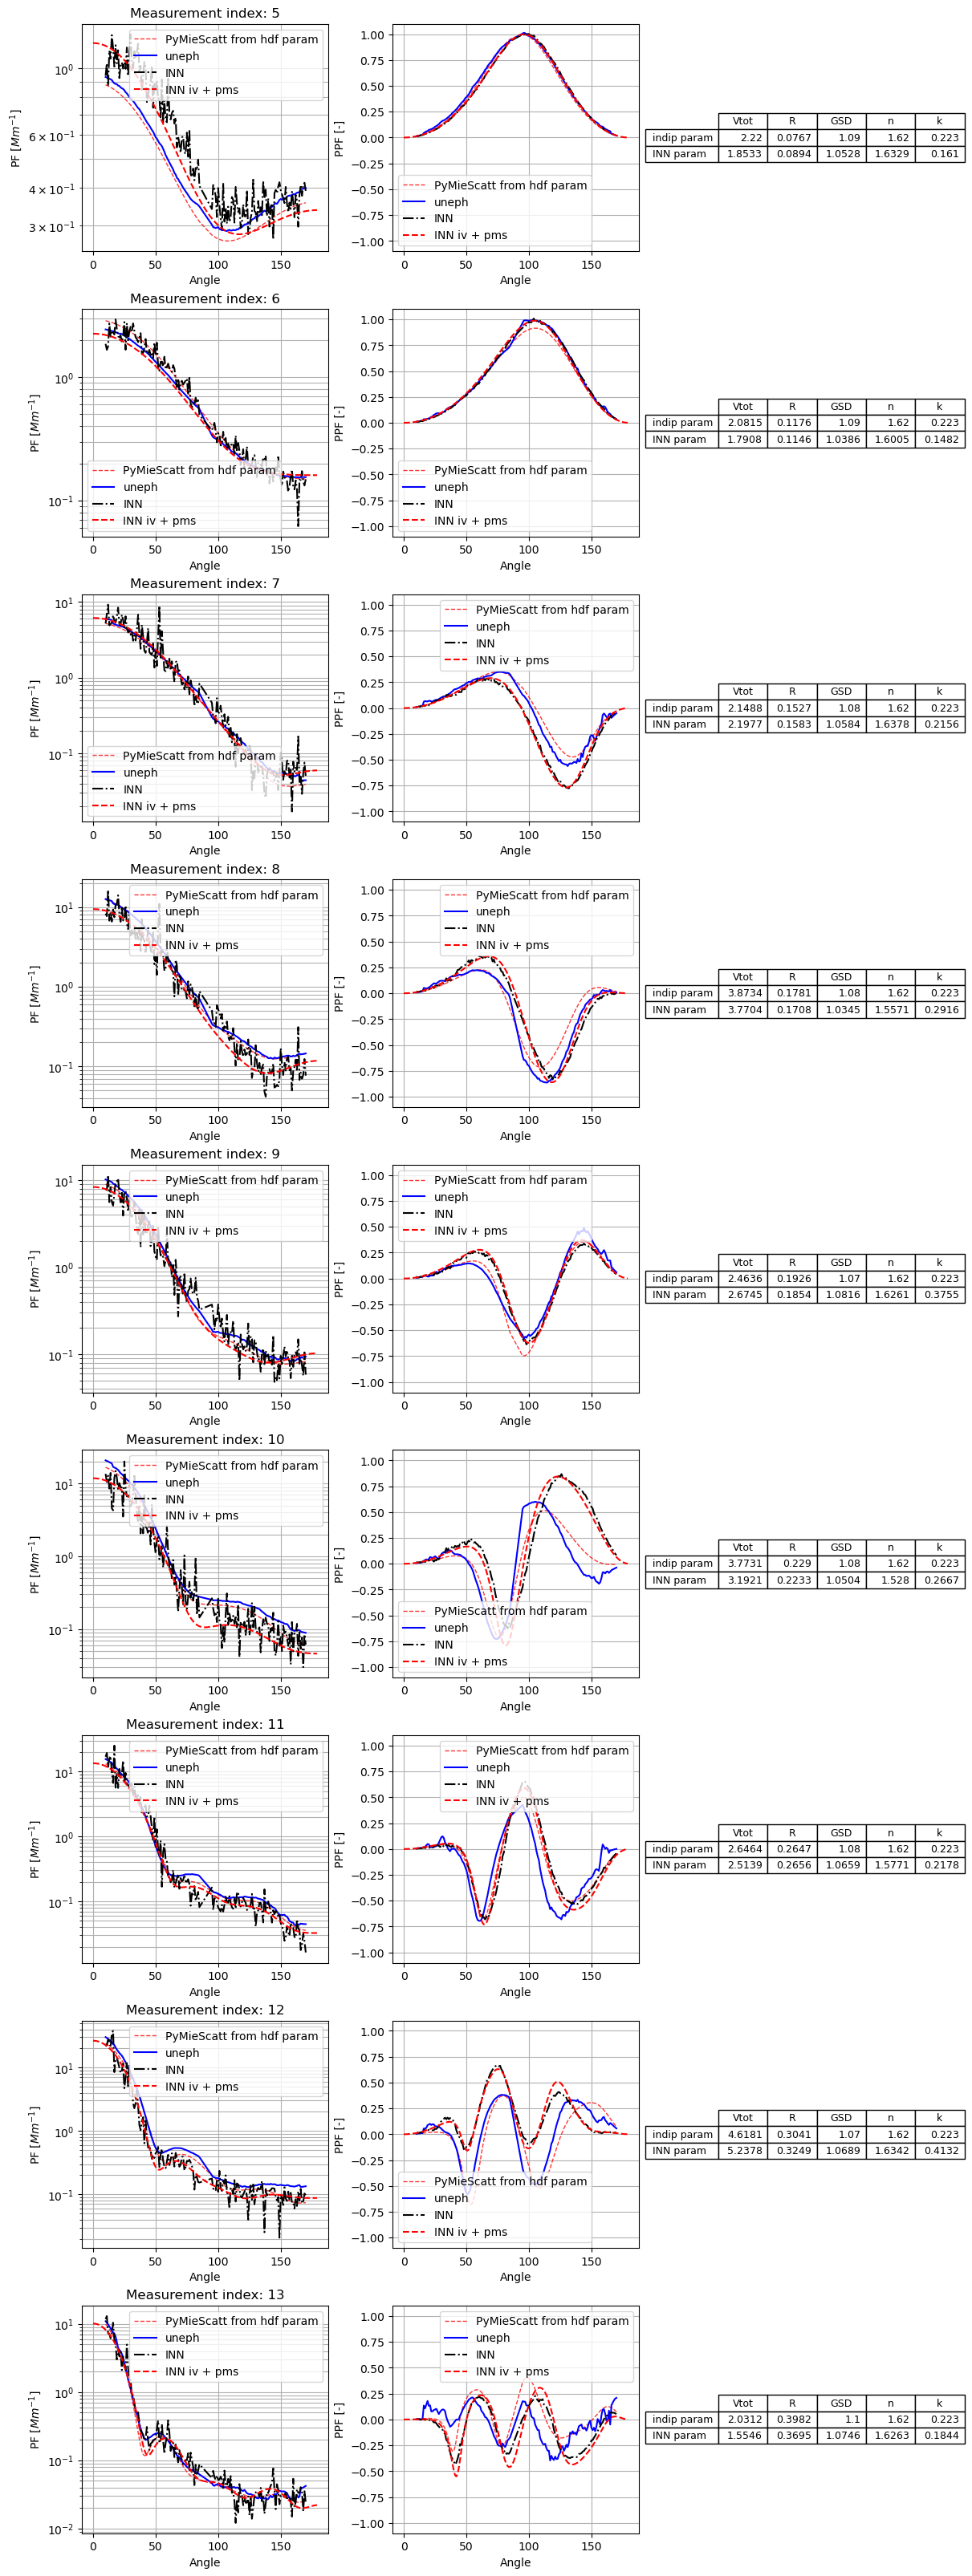

In [18]:
fig, axs = plt.subplots(ncols=3, nrows=9, figsize=(12, 32), constrained_layout=True)

idx = 0
for index in np.arange(5, 14):
    axs[idx, 0].set_title('Measurement index: '+str(index))

    pms_plot, = axs[idx, 0].plot(theta, pms_qoi_plot[F11_list].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_plot, = axs[idx, 1].plot(theta, pms_qoi_plot[PPF_list].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_plot, = axs[idx, 0].plot(theta, uneph_qoi_plot[F11_list].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_plot, = axs[idx, 1].plot(theta, uneph_qoi_plot[PPF_list].loc[index].values, c= 'b', label = 'uneph')
    
    meas_pred_plot, = axs[idx, 0].plot(theta, uneph_qoi_pred_fw_plot[F11_list].loc[index].values,ls='-.', c= 'k', label = 'INN')
    meas_pred_plot, = axs[idx, 1].plot(theta, uneph_qoi_pred_fw_plot[PPF_list].loc[index].values,ls='-.', c= 'k', label = 'INN')
    
    pms_pred_qoi_plot, = axs[idx, 0].plot(angles, pms_pred_qoi.iloc[index, :180], ls='--', c='r', label='INN iv + pms')
    pms_pred_qoi_plot, = axs[idx, 1].plot(angles, pms_pred_qoi.iloc[index, 180:], ls='--', c='r', label='INN iv + pms')

    axs[idx,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[idx,1].set_ylabel('PPF [-]')
    axs[idx,1].set_ylim(-1.1, 1.1)
    axs[idx,0].set_yscale('log')
    for ax in [axs[idx, 0], axs[idx, 1]]:
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_plot, meas_plot, meas_pred_plot, pms_pred_qoi_plot])
        ax.grid(which='both')
        
    # table
    indip_param = uneph_dvar_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    model1_param = uneph_dvar_pred_iv_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)

    col_labels=['Vtot','R','GSD','n', 'k']
    row_labels=['indip param', 'INN param']
    
    # the rectangle is where I want to place the table
    axs[idx, 2].axis('off')
    axs[idx, 2].table(cellText=[indip_param, model1_param],
                  colWidths = [0.2]*5,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center', fontsize=20)
    idx += 1
fig.savefig(f'{plot_dir}/PF_PPF_predi_NGR.jpg')

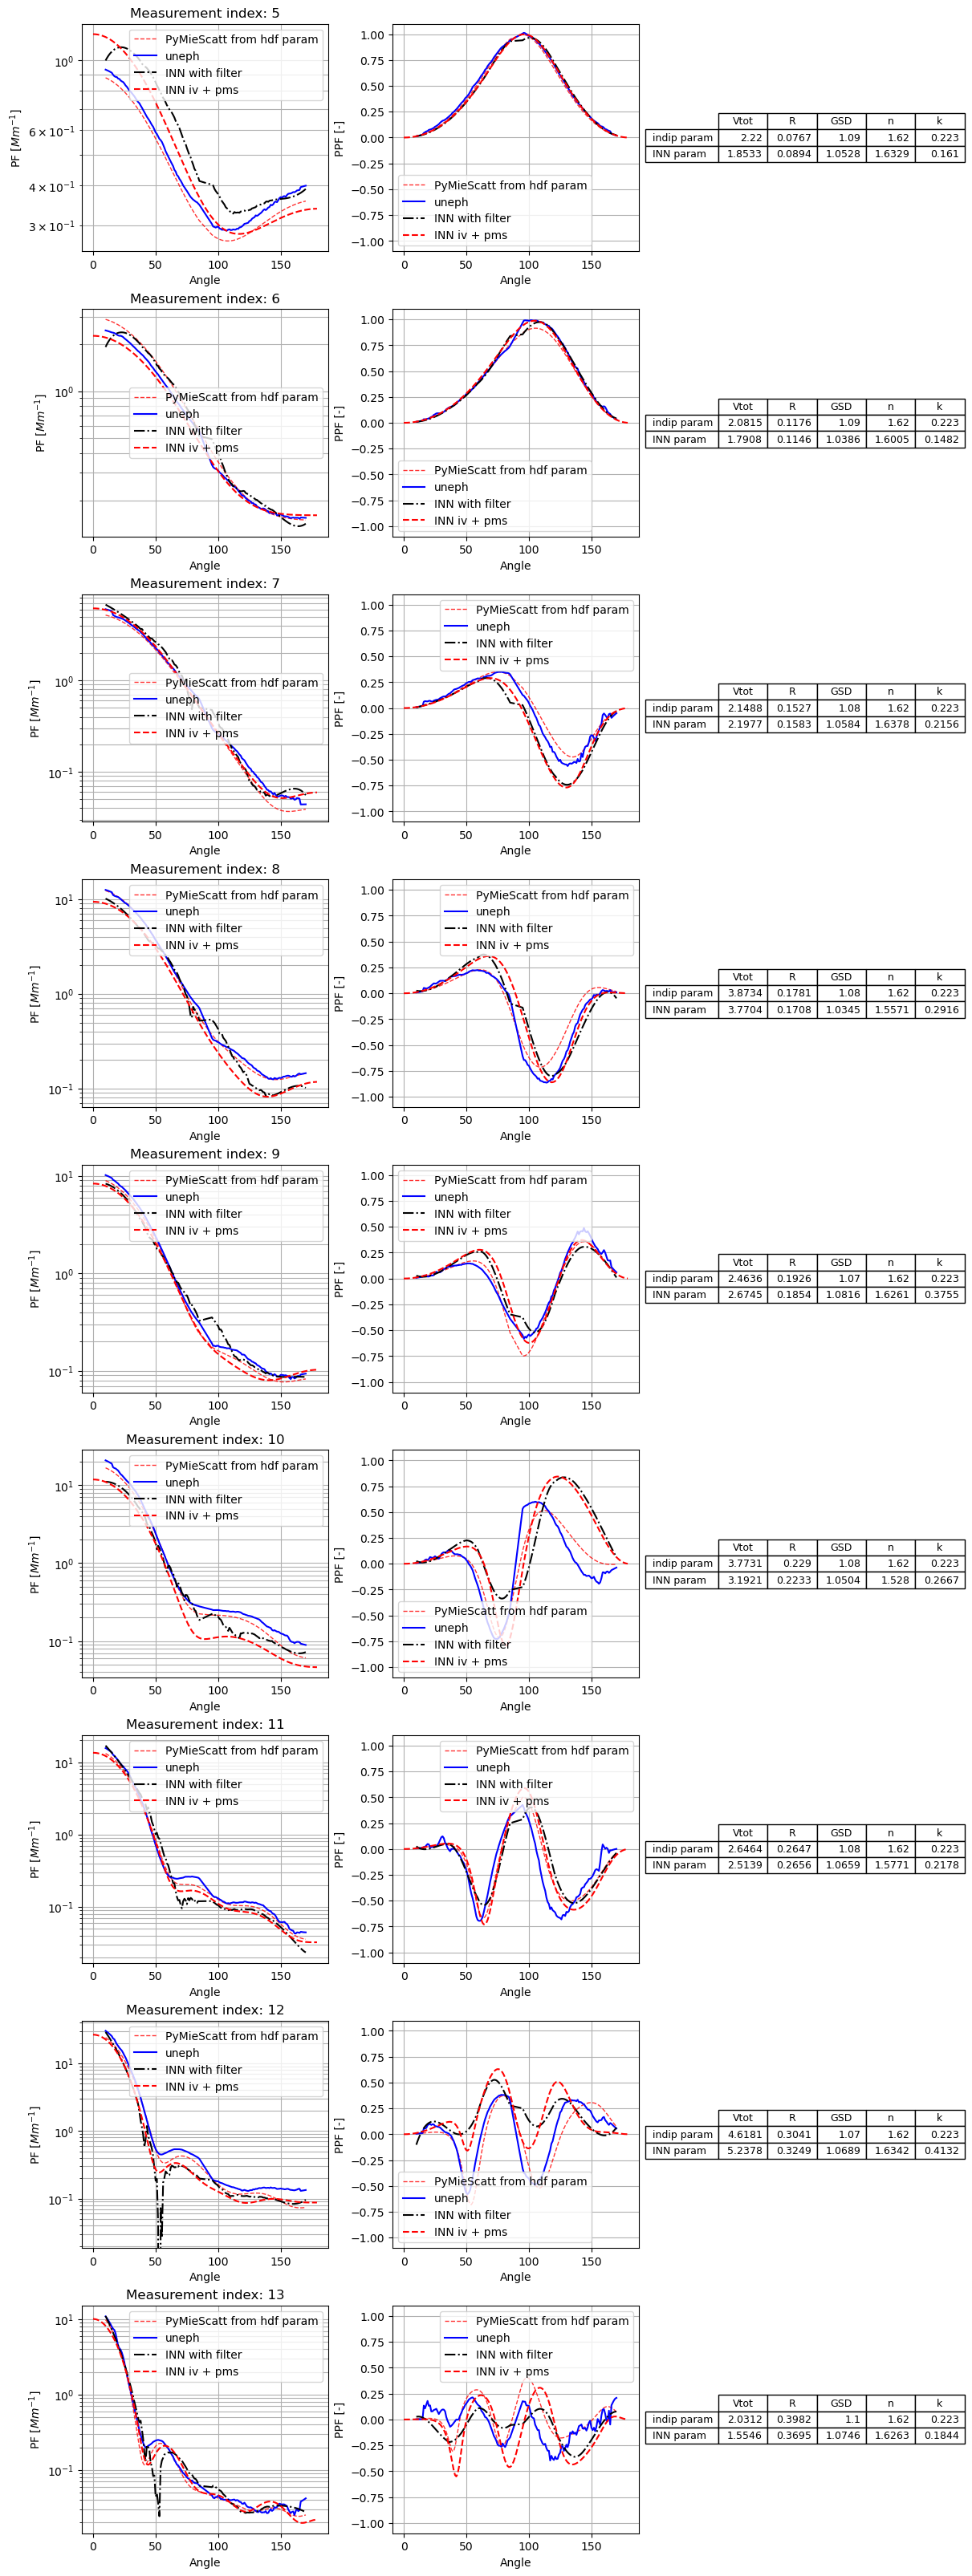

In [19]:
fig, axs = plt.subplots(ncols=3, nrows=9, figsize=(12, 32), constrained_layout=True)

idx = 0
for index in np.arange(5, 14):
    axs[idx, 0].set_title('Measurement index: '+str(index))

    pms_plot, = axs[idx, 0].plot(theta, pms_qoi_plot[F11_list].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_plot, = axs[idx, 1].plot(theta, pms_qoi_plot[PPF_list].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_plot, = axs[idx, 0].plot(theta, uneph_qoi_plot[F11_list].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_plot, = axs[idx, 1].plot(theta, uneph_qoi_plot[PPF_list].loc[index].values, c= 'b', label = 'uneph')
    
    meas_pred_plot, = axs[idx, 0].plot(theta, signal.savgol_filter(uneph_qoi_pred_fw_plot[F11_list].loc[index].values, 53, 3), ls='-.', c= 'k', label = 'INN with filter')
    meas_pred_plot, = axs[idx, 1].plot(theta, signal.savgol_filter(uneph_qoi_pred_fw_plot[PPF_list].loc[index].values, 53, 3), ls='-.', c= 'k', label = 'INN with filter')
    
    pms_pred_qoi_plot, = axs[idx, 0].plot(angles, pms_pred_qoi.iloc[index, :180], ls='--', c='r', label='INN iv + pms')
    pms_pred_qoi_plot, = axs[idx, 1].plot(angles, pms_pred_qoi.iloc[index, 180:], ls='--', c='r', label='INN iv + pms')

    axs[idx,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[idx,1].set_ylabel('PPF [-]')
    axs[idx,1].set_ylim(-1.1, 1.1)
    axs[idx,0].set_yscale('log')
    for ax in [axs[idx, 0], axs[idx, 1]]:
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_plot, meas_plot, meas_pred_plot, pms_pred_qoi_plot])
        ax.grid(which='both')
        
    # table
    indip_param = uneph_dvar_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    model1_param = uneph_dvar_pred_iv_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)

    col_labels=['Vtot','R','GSD','n', 'k']
    row_labels=['indip param', 'INN param']
    
    # the rectangle is where I want to place the table
    axs[idx, 2].axis('off')
    axs[idx, 2].table(cellText=[indip_param, model1_param],
                  colWidths = [0.2]*5,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center', fontsize=20)
    idx += 1
fig.savefig(f'{plot_dir}/PF_PPF_predi_NGR_filtered.jpg')

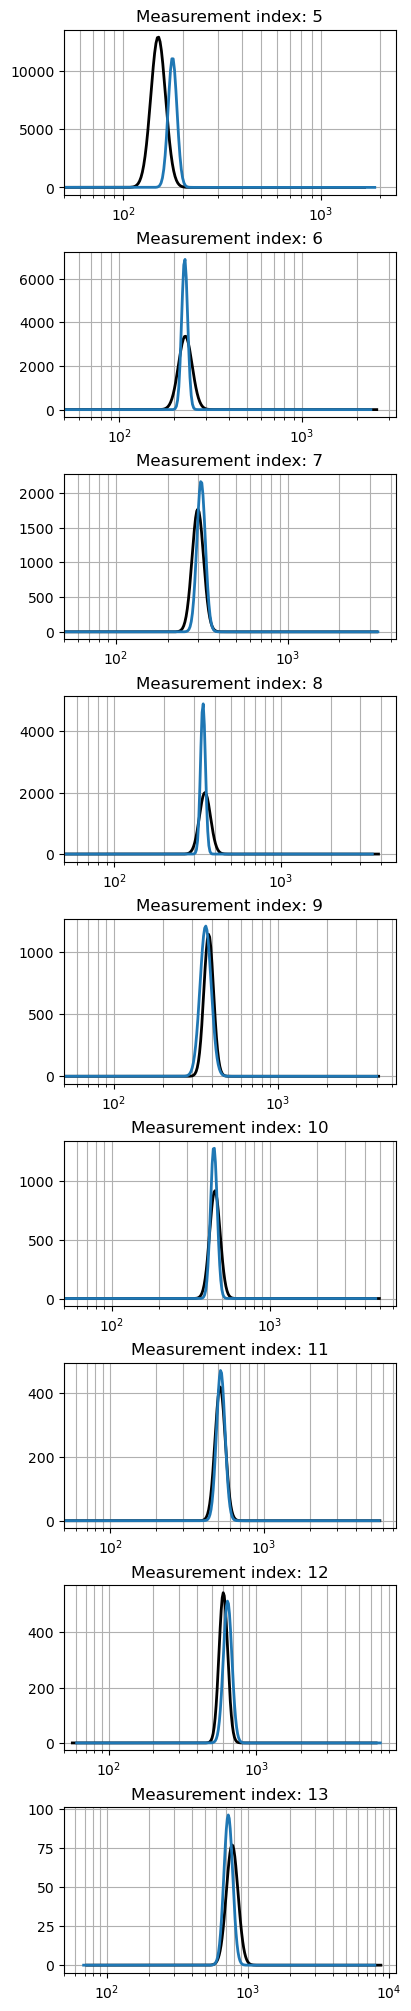

In [20]:
fig, axs = plt.subplots(ncols=1, nrows=9, figsize=(4, 20), constrained_layout=True)

idx = 0
for index, row in uneph_dvar_plot[5:].iterrows():
    
    axs[idx].set_title('Measurement index: '+str(index))
    
    # measurements
    DmedianV = row['RmedianV']*2  # [um]
    lowerD = DmedianV / row['GSD'] / nstd
    upperD = DmedianV * row['GSD'] * nstd
    D_array = np.logspace(np.log10(lowerD*1e3),np.log10(upperD*1e3), 301) # nm
    DmedianN = (np.exp(np.log(row['RmedianV']*2) - (3*np.log(row['GSD'])**2))) *1e3   # [nm]
    Ntot = 6 / np.pi * row['Vtot']*1e9 / (np.exp((3*np.log(DmedianN)) + (4.5*np.log(row['GSD'])**2))) # [cm^-3]
    axs[idx].plot(D_array, lognormal(D_array, DmedianN, row['GSD'], Ntot), c='k', ls='-', lw=2, label='measurement')

    # predictions
    DmedianV_pred = uneph_dvar_pred_iv_plot['RmedianV'].iloc[index]*2  # [um]
    lowerD_pred = DmedianV_pred / uneph_dvar_pred_iv_plot['GSD'].iloc[index] / nstd
    upperD_pred = DmedianV_pred * uneph_dvar_pred_iv_plot['GSD'].iloc[index] * nstd
    D_array_pred = np.logspace(np.log10(lowerD_pred*1e3),np.log10(upperD_pred*1e3), 301) # nm
    DmedianN_pred = (np.exp(np.log(uneph_dvar_pred_iv_plot['RmedianV'].iloc[index]*2) - (3*np.log(uneph_dvar_pred_iv_plot['GSD'].iloc[index])**2))) *1e3   # [nm]
    Ntot_pred = 6 / np.pi * uneph_dvar_pred_iv_plot['Vtot'].iloc[index]*1e9 / (np.exp((3*np.log(DmedianN_pred)) + (4.5*np.log(uneph_dvar_pred_iv_plot['GSD'].iloc[index])**2))) # [cm^-3]
    axs[idx].plot(D_array_pred, lognormal(D_array_pred, DmedianN_pred, uneph_dvar_pred_iv_plot['GSD'].iloc[index], Ntot_pred), c='C0', ls='-', lw=2, label='INN prediction')

    axs[idx].set_xscale('log')
    axs[idx].grid(which='both')
    axs[idx].set_xlim(50, )

    idx += 1
fig.savefig(f'{plot_dir}/size_distrib_predi_NIGR.jpg')

### Metrics

#### 1. Mean absolute error

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

In [21]:
MAE_all_dvar = []
print('MAE dvar:')
for col in uneph_dvar_plot.keys():
    MAE = mean_absolute_error(uneph_dvar_plot[col], uneph_dvar_pred_iv_plot[col])
    MAE_all_dvar.append(MAE)
    print('%s : \t %.3f' %(col, MAE))
MAE_all_dvar = np.array(MAE_all_dvar)

print('\n')

MAE_qoi = []
for col in uneph_qoi.keys():
    MAE = mean_absolute_error(uneph_qoi[col], uneph_qoi_pred_fw[col])
    MAE_qoi.append(MAE)
MAE_qoi = np.array(MAE_qoi)
MAE_qoi = pd.DataFrame([MAE_qoi], columns = np.concatenate([F11_list, PPF_list]), index=['MAE_qoi'])
print(MAE_qoi.apply(pd.DataFrame.describe, axis = 1))

MAE dvar:
Vtot : 	 0.469
RmedianV : 	 0.016
GSD : 	 0.026
n : 	 0.143
k : 	 0.051


         count      mean       std       min     25%       50%      75%  \
MAE_qoi  304.0  0.289629  0.152637  0.005187  0.2017  0.255179  0.37604   

              max  
MAE_qoi  0.786208  


#### 2. Mean absolute percentage error

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

In [22]:
MAPE_all_dvar = []
print('MAPE dvar:')
for col in uneph_dvar_plot.keys():
    MAPE = mean_absolute_percentage_error(uneph_dvar_plot[col], uneph_dvar_pred_iv_plot[col])
    MAPE_all_dvar.append(MAPE)
    print('%s : \t %.3f' %(col, MAPE))
MAPE_all_dvar = np.array(MAPE_all_dvar)

print('\n')

MAPE_qoi = []
for col in uneph_qoi.keys():
    MAPE = mean_absolute_percentage_error(uneph_qoi[col], uneph_qoi_pred_fw[col])
    MAPE_qoi.append(MAPE)
MAPE_qoi = np.array(MAPE_qoi)
MAPE_qoi = pd.DataFrame([MAPE_qoi], columns = np.concatenate([F11_list, PPF_list]), index=['MAPE_qoi'])
print(MAPE_qoi.apply(pd.DataFrame.describe, axis = 1))

MAPE dvar:
Vtot : 	 0.158
RmedianV : 	 0.066
GSD : 	 0.024
n : 	 0.090
k : 	 48.415


          count      mean        std      min       25%       50%       75%  \
MAPE_qoi  304.0  2.998369  13.825471  0.14035  0.452472  0.863618  1.606144   

                 max  
MAPE_qoi  151.402549  


#### 3. Root mean squared error

RMSE = $\frac{1}{n_s}\sum^{n_s}_{i=0}{(y^i_{true}-y^i_{pred})^2}$ 

In [23]:
RMSE_dvar = []
print('RMSE dvar:')
for col in uneph_dvar_plot.keys():
    RMSE = np.sqrt(mean_squared_error(uneph_dvar_plot[col], uneph_dvar_pred_iv_plot[col]))
    RMSE_dvar.append(RMSE)
    print('%s : \t %.3f' %(col, RMSE))
RMSE_dvar = pd.DataFrame(RMSE_dvar, index=uneph_dvar_plot.keys()).T

print('\n')

RMSE_qoi = []
for col in uneph_qoi.keys():
    RMSE = np.sqrt(abs(mean_squared_error(uneph_qoi[col], uneph_qoi_pred_fw[col])))
    RMSE_qoi.append(RMSE)
RMSE_qoi = np.array(RMSE_qoi)
RMSE_qoi = pd.DataFrame([RMSE_qoi], columns = np.concatenate([F11_list, PPF_list]), index=['RMSE_qoi'])
print(RMSE_qoi.apply(pd.DataFrame.describe, axis = 1))

RMSE dvar:
Vtot : 	 0.736
RmedianV : 	 0.022
GSD : 	 0.029
n : 	 0.315
k : 	 0.075


          count      mean       std       min       25%       50%      75%  \
RMSE_qoi  304.0  0.404268  0.228288  0.007197  0.279183  0.346956  0.50705   

               max  
RMSE_qoi  1.419241  


#### 4. Explained variance score


EVS = $1- \frac{VAR(y_{true}-y_{pred})}{VAR(y_{true})}$


VAR = $\frac{1}{n}\sum^{n}_{i=1}{(y - \bar{y})}$

In [24]:
EVS_dvar = []
print('EVS dvar:')
for col in uneph_dvar_plot.keys():
    EVS = explained_variance_score(uneph_dvar_plot[col], uneph_dvar_pred_iv_plot[col])
    EVS_dvar.append(EVS)
    print('%s : \t %.3f' %(col, EVS))
EVS_dvar = pd.DataFrame(EVS_dvar, index=uneph_dvar_plot.keys()).T

print('\n')

EVS_qoi = []
for col in uneph_qoi.keys():
    EVS = explained_variance_score(uneph_qoi[col], uneph_qoi_pred_fw[col])
    EVS_qoi.append(EVS)
EVS_qoi = np.array(EVS_qoi)
EVS_qoi = pd.DataFrame([EVS_qoi], columns = np.concatenate([F11_list, PPF_list]), index=['EVS_qoi'])
print(EVS_qoi.apply(pd.DataFrame.describe, axis = 1))

EVS dvar:
Vtot : 	 0.578
RmedianV : 	 0.972
GSD : 	 -0.326
n : 	 -448.904
k : 	 0.552


         count      mean       std       min       25%      50%       75%  \
EVS_qoi  304.0  0.437236  0.496144 -3.286164  0.344708  0.54998  0.719697   

              max  
EVS_qoi  0.940607  


In [25]:
EVS_qoi.sort_values(by=EVS_qoi.index[0], axis = 1, ascending=True).iloc[0, :10]

F11_79    -3.286164
F11_130   -3.005082
F11_56    -2.301780
F11_60    -2.142876
F11_61    -1.450155
PPF_11    -1.081554
F11_124   -1.019056
F11_116   -0.530857
F11_105   -0.507288
PPF_29    -0.481026
Name: EVS_qoi, dtype: float64

In [26]:
EVS_qoi.apply(pd.DataFrame.describe, axis=1)

count      mean       std       min       25%      50%       75%  \
EVS_qoi  304.0  0.437236  0.496144 -3.286164  0.344708  0.54998  0.719697   

              max  
EVS_qoi  0.940607